***
 # Многослойные нейросети, сверточные автокодировщики и их  применение в задаче распознавания изображений
***
_Цыпин Артем<br>
317 группа<br>
13.03.2018_

## Введение

В данном отчете будут рассмотрены многослойные и сверточные нейросети, сверточные автокодировщики а также их применение в задаче классификации. В частности, будут рассмотрены способы улучшения качества классификации с помощью использования неразмеченных изображений, а также способы понижения размерности признакового пространства объектов для ускорения обучения и повышения качества классификации таких традиционных моделей, как _MultinomialRegression_ и _RandomForestClassifier_.<br>
Также будут проведены эксперименты на датасете изображений stl10, с целью исследования поведения моделей при различных значниях параметров и использования неразмеченной части данных для повышения качества классификации.

In [151]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import math
import time
from torch.autograd import Variable
from torch import nn
from sklearn.ensemble import RandomForestClassifier

## Код

Ниже приведен код нескольких вспомогательных функций, а также код класса _ConvAutoEncoder_, который является реализацией сверточного автокодировщика и сверточной нейросети одновременно.

In [152]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [153]:
def get_accuracy(accuracy, pos1, pos2, stride=1, train=True):
    if train is True:
        pos = 0
    else:
        pos = 1
    accuracy_ = [i[pos] for i in accuracy]
    return accuracy_[pos1:pos2:stride]

Подчсет точности классификации:

In [154]:
def compute_accuracy(net, dataset, **kwargs):
    correct=0
    total=0
    for i, data in enumerate(dataset):
        images, labels = data
        if (kwargs):
            outputs = net.forward(Variable(images), kwargs)
        else:
            outputs = net.forward(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()

    print('Accuracy on dataset: {:.3f}'.format(correct / total))
    return correct / total

Оптимизация нейросети:

In [155]:
def optimize_net(net, criterion, optimizer, dataset, num_epochs=1, show_progress=True, **kwargs):

    for epoch in range(num_epochs):
    
        running_loss = 0;
        for i, data in enumerate(dataset):
            imgs, labels = data
            imgs, labels = Variable(imgs), Variable(labels)
            optimizer.zero_grad()
            if (kwargs):
                outputs = net.forward(imgs, kwargs)
            else:
                outputs = net.forward(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.data[0]
            if ((i + 1) % 500 == 0) and (show_progress is True):
                print("[{:d}, {:5d}] loss: {:.3f}".format(epoch + 1, i + 1, running_loss / 500))
                running_loss = 0

Оптимизация автокодировщика. Отличается от функции для оптимизации нейросети тем, что оптимизируется тождественная функция.

In [156]:
def optimize_encoder(net, criterion, optimizer, dataset, num_epochs=1, show_progress=True):

    for epoch in range(num_epochs):
    
        running_loss = 0;
        for i, data in enumerate(dataset):
            imgs, _ = data
            imgs = Variable(imgs)
            optimizer.zero_grad()
            outputs = net.forward(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.data[0]
            if ((i + 1) % 2000 == 0) and (show_progress is True):
                print("[{:d}, {:5d}] loss: {:.3f}".format(epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0

Реализация автокодировщика и сверточной нейросети с произвольным количеством сверточных блоков. Способы прохода по графу вычислений задаются флагами в методе forward. В качестве нелинейного преобразования на последнем слое декодера используется функция __tanh__, областью значений которой является отрезок $ [-1, 1] $, так как значения пикселей нормализованного изображения лежат в этом отрезке.

In [157]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, input_size=(3, 32, 32), layers_num=2, conv_out_channels=(6, 6), conv_kernel_size=(4, 4),
                 conv_stride=(2, 1), pool_kernel_size=(2, 1), pool_stride=(1, 1), conv_padding=(0, 0),
                 linear_layers_num=2, linear_out_channels=(84, 10)):
        super(ConvAutoEncoder, self).__init__()
        self.input_size = input_size
        self.layers_num = layers_num
        self.linear_layers_num = linear_layers_num
        conv_in_channels = [input_size[0]]
        conv_in_channels.extend(conv_out_channels[:-1:])
        
        self.conv = nn.ModuleList([nn.Conv2d(conv_in_channels[i], conv_out_channels[i], 
                                  kernel_size=conv_kernel_size[i], stride=conv_stride[i], padding=conv_padding[i])
                                  for i in range(layers_num)])
        self.pool = nn.ModuleList([nn.MaxPool2d(kernel_size=pool_kernel_size[i],
                                  stride=pool_stride[i], return_indices=True) for i in range(layers_num)])
        self.unpool = nn.ModuleList([nn.MaxUnpool2d(kernel_size=pool_kernel_size[- 1 - i],
                                    stride=pool_stride[-1 - i]) for i in range(layers_num)])
        self.convTrans = nn.ModuleList([nn.ConvTranspose2d(conv_out_channels[-1 - i], 
                                       conv_in_channels[-1 -i], kernel_size=conv_kernel_size[-1 - i],
                                       stride=conv_stride[-1 - i], padding=conv_padding[-1 - i]) 
                                       for i in range(layers_num)])
       
        output_size_x = input_size[1]
        output_size_y = input_size[2]
        
        for i in range(layers_num):
            output_size_x = math.floor((output_size_x + 2 * conv_padding[i]  - conv_kernel_size[i]) / conv_stride[i] + 1)
            output_size_y = math.floor((output_size_y + 2 * conv_padding[i] - conv_kernel_size[i]) / conv_stride[i] + 1)
            output_size_x = math.floor((output_size_x - pool_kernel_size[i]) / pool_stride[i] + 1)
            output_size_y = math.floor((output_size_y - pool_kernel_size[i]) / pool_stride[i] + 1)
        
        linear_in_channels = [conv_out_channels[-1] * output_size_x * output_size_y]
        linear_in_channels.extend(linear_out_channels[:-1:])
        self.linear = nn.ModuleList([nn.Linear(linear_in_channels[i], linear_out_channels[i]) for i in range(linear_layers_num)])

    def forward(self, x, AutoEncoder=True, TransformObjects=False):
        indices = []
        output_size = []
        for i in range(self.layers_num):
            x = F.relu(self.conv[i](x))
            output_size.append(x.size())
            x, ind = self.pool[i](x)
            indices.append(ind)
        if (TransformObjects is True):
            return x.view(-1, self.num_features(x))
        if (AutoEncoder is True):
            for i in range(self.layers_num):
                x = self.unpool[i](x, indices[-1 - i], output_size=output_size[-1 - i])
                if i == self.layers_num - 1:
                    x = F.tanh(self.convTrans[i](x))
                else:
                    x = F.relu(self.convTrans[i](x))
        else:
            x = x.view(-1, self.num_features(x))
            for i in range(self.linear_layers_num - 1):
                x = F.relu(self.linear[i](x))
            x = self.linear[-1](x)
        return x
    
    def num_features(self, x):
        return int(np.array(x.size()[1::]).prod())

#  Эксперименты
Загрузка данных:

In [158]:
transform = transforms.Compose([transforms.Resize(
    size=(32, 32)), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

unlabeled = torchvision.datasets.STL10(
    root='./data', split='unlabeled', download=True, transform=transform)
unlabeledloader = torch.utils.data.DataLoader(
    unlabeled, batch_size=4, shuffle=True)

trainset = torchvision.datasets.STL10(
    root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.STL10(
    root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [159]:
classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

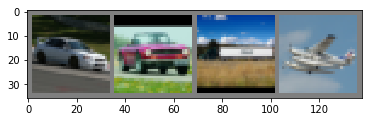

In [160]:
dataiter = iter(trainloader)
imgs, label = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))

plt.show()

## Эксперимент №1

Целью первого эксперимента является обучение мультиномильной регрессии и случайного леса на обучающей части датасета и проверка качества классификации на тестовой части датасета. Показатели точности этих двух моделей можно будет использовать в качестве бейзлайна для следующих экспериментов.

Зададим мультиномиальную регрессию как однослойную нейросеть с кросс-энтропийной функцией потерь и оценим качество классификации:

In [161]:
class MultinomialRegression(nn.Module):
    def __init__(self, input_size):
        self.input_size = input_size
        super(MultinomialRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, len(classes))
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        return x

In [162]:
mult_regression = MultinomialRegression(32 * 32 * 3)

In [163]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(mult_regression.parameters(), lr=0.001, weight_decay=1e-5)

optimize_net(net=mult_regression, criterion=criterion, optimizer=optimizer, dataset=trainloader, num_epochs=10, show_progress=False)

In [164]:
compute_accuracy(mult_regression, testloader)

Accuracy on dataset: 0.367


0.367125

Переводим данные в формат, приемлимый для _RandomForestClassifier_.

In [165]:
dataiter = iter(trainloader)
imgs, label = next(dataiter)
X = np.empty((0, np.array(imgs.size()[1::]).prod()))
y = []


for i, data in enumerate(trainloader):
    imgs, labels = data
    num_features = np.array(imgs.size()[1::]).prod()
    tmp = imgs.numpy().reshape(-1, num_features)
    X = np.vstack((X, tmp))
    y += list(labels)

y = np.array(y)

In [166]:
dataiter = iter(testloader)
imgs, label = next(dataiter)
X_test = np.empty((0, np.array(imgs.size()[1::]).prod()))
y_test = []


for i, data in enumerate(testloader):
    imgs, labels = data
    num_features = np.array(imgs.size()[1::]).prod()
    tmp = imgs.numpy().reshape(-1, num_features)
    X_test = np.vstack((X_test, tmp))
    y_test += list(labels)

y_test = np.array(y_test)

In [167]:
cl = RandomForestClassifier(n_estimators=300)
cl.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [168]:
predictions = cl.predict(X_test)

In [169]:
print("Accuracy of RandomForestClassifier: {:.3f}".format((predictions==y_test).sum() / y_test.shape[0]))

Accuracy of RandomForestClassifier: 0.429


Как можно видеть из данных, приведенных выше, простая модель вроде мультиномиальной регрессии дает достаточно низкий показатель точности, который явно можно улучшить.

## Эксперимент №2

Данный эксперимент заключается в исследовании влияния размера ядра свертки, количества фильтров в сверточном слое, а также количества сверточных блоков в нейросети на время обучения и качество модели. Далее будет исследовано влияние использования momentum при оптимизации методом стохастического градиентного спуска.  

Для начала найдем наилучший размер ядра свертки и число фильтров в сверточной нейросети с одним сверточным блоком.

In [170]:
times1 = []
accuracy1 = []

kernel_size_list = [i for i in range(2, 9)]
filters_num_list = [i for i in range(5, 41, 5)]

criterion = nn.CrossEntropyLoss()

for kernel_size in kernel_size_list:
    for filters_num  in filters_num_list:
        auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=1, conv_out_channels=[filters_num], 
                                   conv_kernel_size=[kernel_size], conv_stride=[1], pool_kernel_size=[2],
                                   pool_stride=[2], conv_padding=[0],linear_layers_num=3,linear_out_channels=[120, 84, 10])
        
        optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5)
        
        print("Kernel_size: {:d}, filters_num: {:d}".format(kernel_size, filters_num))
        
        start = time.time()
        optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=4,
                     dataset=trainloader, AutoEncoder=False, show_progress=False)
        times1.append(time.time() - start)
        
        train_accuracy = compute_accuracy(net=auto_enc, dataset=trainloader, AutoEncoder=False)        
        
        test_accuracy = compute_accuracy(net=auto_enc, dataset=testloader, AutoEncoder=False)
        
        accuracy1.append((train_accuracy, test_accuracy))

Kernel_size: 2, filters_num: 5
Accuracy on dataset: 0.218
Accuracy on dataset: 0.216
Kernel_size: 2, filters_num: 10
Accuracy on dataset: 0.286
Accuracy on dataset: 0.277
Kernel_size: 2, filters_num: 15
Accuracy on dataset: 0.273
Accuracy on dataset: 0.266
Kernel_size: 2, filters_num: 20
Accuracy on dataset: 0.328
Accuracy on dataset: 0.326
Kernel_size: 2, filters_num: 25
Accuracy on dataset: 0.293
Accuracy on dataset: 0.288
Kernel_size: 2, filters_num: 30
Accuracy on dataset: 0.324
Accuracy on dataset: 0.309
Kernel_size: 2, filters_num: 35
Accuracy on dataset: 0.306
Accuracy on dataset: 0.300
Kernel_size: 2, filters_num: 40
Accuracy on dataset: 0.330
Accuracy on dataset: 0.330
Kernel_size: 3, filters_num: 5
Accuracy on dataset: 0.231
Accuracy on dataset: 0.227
Kernel_size: 3, filters_num: 10
Accuracy on dataset: 0.253
Accuracy on dataset: 0.254
Kernel_size: 3, filters_num: 15
Accuracy on dataset: 0.309
Accuracy on dataset: 0.305
Kernel_size: 3, filters_num: 20
Accuracy on dataset: 0.3

__Замечание__. На всех графиках ниже точность и время обучения замерены после 4 эпох.

<a id='time_filters'></a>

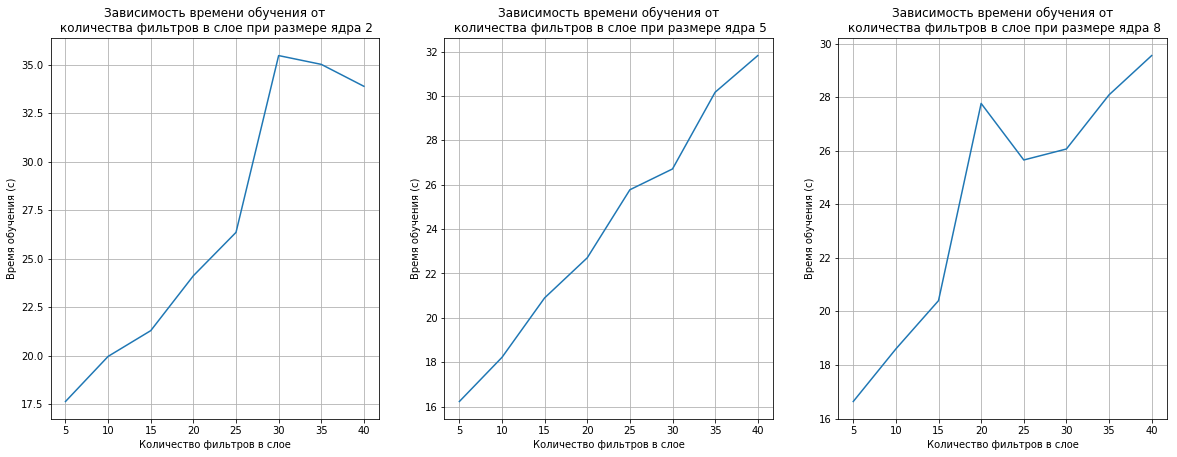

In [171]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

ax1.plot(filters_num_list, times1[:8:])
ax1.set_title(u"Зависимость времени обучения от\n количества фильтров в слое при размере ядра 2")
ax1.set_xlabel(u"Количество фильтров в слое")
ax1.set_ylabel(u"Время обучения (с)")
ax1.grid()
ax1.legend()

ax2.plot(filters_num_list, times1[24:32:])
ax2.set_title(u"Зависимость времени обучения от\n количества фильтров в слое при размере ядра 5")
ax2.set_xlabel(u"Количество фильтров в слое")
ax2.set_ylabel(u"Время обучения (с)")
ax2.grid()
ax2.legend()

ax3.plot(filters_num_list, times1[48::])
ax3.set_title(u"Зависимость времени обучения от\n количества фильтров в слое при размере ядра 8")
ax3.set_xlabel(u"Количество фильтров в слое")
ax3.set_ylabel(u"Время обучения (с)")
ax3.grid()
ax3.legend()

plt.show()

На графиках в ячейке [Зависимость времени обучения от числа фильтров](#time_filters) изображена зависимость времени обучения сверточной нейросети от количества фильтров при различных значениях размера фильтров. Из них видно, что зависимость визуально близка к линейной.

<a id='time_kernels'></a>

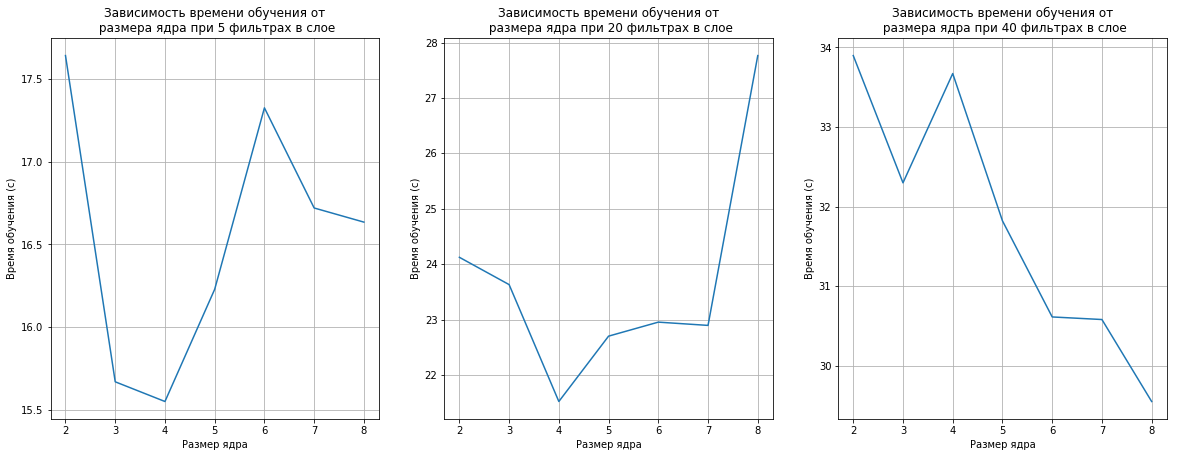

In [172]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

ax1.plot(kernel_size_list, times1[::8])
ax1.set_title(u"Зависимость времени обучения от\n размера ядра при 5 фильтрах в слое")
ax1.set_xlabel(u"Размер ядра")
ax1.set_ylabel(u"Время обучения (с)")
ax1.grid()
ax1.legend()

ax2.plot(kernel_size_list, times1[3::8])
ax2.set_title(u"Зависимость времени обучения от\n размера ядра при 20 фильтрах в слое")
ax2.set_xlabel(u"Размер ядра")
ax2.set_ylabel(u"Время обучения (с)")
ax2.grid()
ax2.legend()

ax3.plot(kernel_size_list, times1[7::8])
ax3.set_title(u"Зависимость времени обучения от\n размера ядра при 40 фильтрах в слое")
ax3.set_xlabel(u"Размер ядра")
ax3.set_ylabel(u"Время обучения (с)")
ax3.grid()
ax3.legend()

plt.show()

На графиках в ячейке [Зависимость времени обучения от размера фильтров](#time_kernels) изображена зависимость времени обучения сверточной нейросети от размера фильтров при различных значениях количества фильтров. Из графиков можно сделать вывод, что четкой зависимости между этими двумя величинами нет. Это объясняется тем, что операция поэлементного перемножения матриц не является ресурсоемкой, поэтому время обучения зависит лишь от числа фильтров в слое.

<a id='acc_filters'></a>

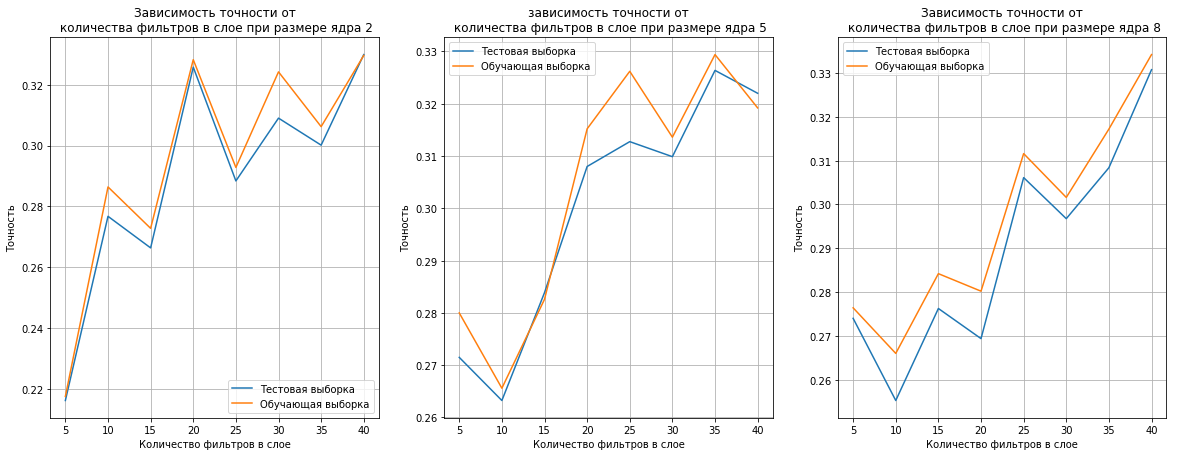

In [173]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

ax1.plot(filters_num_list, get_accuracy(accuracy1, 0, 8, train=False), label="Тестовая выборка")
ax1.plot(filters_num_list, get_accuracy(accuracy1, 0, 8), label="Обучающая выборка")
ax1.set_title(u"Зависимость точности от\n количества фильтров в слое при размере ядра 2")
ax1.set_xlabel(u"Количество фильтров в слое")
ax1.set_ylabel(u"Точность")
ax1.grid()
ax1.legend()

ax2.plot(filters_num_list, get_accuracy(accuracy1, 24, 32, train=False), label="Тестовая выборка")
ax2.plot(filters_num_list, get_accuracy(accuracy1, 24, 32), label="Обучающая выборка")
ax2.set_title(u"зависимость точности от\n количества фильтров в слое при размере ядра 5")
ax2.set_xlabel(u"Количество фильтров в слое")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()

ax3.plot(filters_num_list, get_accuracy(accuracy1, 48, 56, train=False), label="Тестовая выборка")
ax3.plot(filters_num_list, get_accuracy(accuracy1, 48, 56), label="Обучающая выборка")
ax3.set_title(u"Зависимость точности от\n количества фильтров в слое при размере ядра 8")
ax3.set_xlabel(u"Количество фильтров в слое")
ax3.set_ylabel(u"Точность")
ax3.grid()
ax3.legend()

plt.show()

На графиках в ячейке [Зависимость точности от числа фильтров](#acc_filters) изображена зависимость точности классификации сверточной нейросети от количества фильтров при различных значениях размера фильтров. Из графиков видно, что наилучшие показатели точности достигаются при количестве фильтров от 25 до 35 и являются самыми высокими при 35 фильтрах в слое.

<a id='acc_kernels'></a>

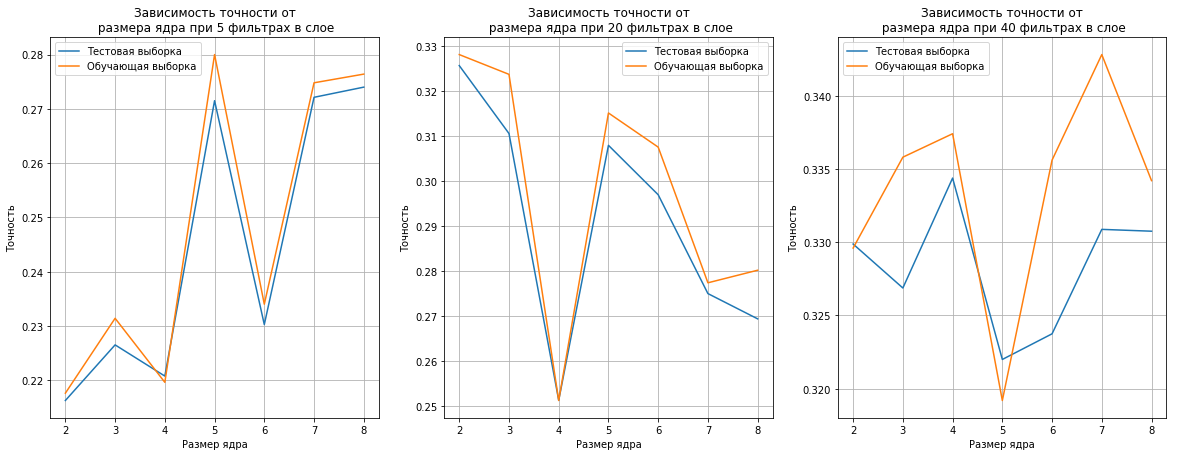

In [174]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

ax1.plot(kernel_size_list, get_accuracy(accuracy1, 0, 56, stride=8, train=False), label="Тестовая выборка")
ax1.plot(kernel_size_list, get_accuracy(accuracy1, 0, 56, stride=8), label="Обучающая выборка")
ax1.set_title(u"Зависимость точности от\n размера ядра при 5 фильтрах в слое")
ax1.set_xlabel(u"Размер ядра")
ax1.set_ylabel(u"Точность")
ax1.grid()
ax1.legend()

ax2.plot(kernel_size_list, get_accuracy(accuracy1, 3, 56, stride=8, train=False), label="Тестовая выборка")
ax2.plot(kernel_size_list, get_accuracy(accuracy1, 3, 56, stride=8), label="Обучающая выборка")
ax2.set_title(u"Зависимость точности от\n размера ядра при 20 фильтрах в слое")
ax2.set_xlabel(u"Размер ядра")
ax2.set_ylabel(u"Точность")
ax2.grid()
ax2.legend()

ax3.plot(kernel_size_list, get_accuracy(accuracy1, 7, 56, stride=8, train=False), label="Тестовая выборка")
ax3.plot(kernel_size_list, get_accuracy(accuracy1, 7, 56, stride=8), label="Обучающая выборка")
ax3.set_title(u"Зависимость точности от\n размера ядра при 40 фильтрах в слое")
ax3.set_xlabel(u"Размер ядра")
ax3.set_ylabel(u"Точность")
ax3.grid()
ax3.legend()

plt.show()

На графиках в ячейке [Зависимость точности от размера фильтров](#acc_kernels) изображена зависимость точности классификации сверточной нейросети от размера фильтров при различных значениях количества фильтров. На графиках не наблюдается четкой зависимости между этими величинами, так что выберем для дальнейших исседований параметры, с которыми модель дает наилучшее качество: $ kernel\_size = 5 $ и $ filters\_num = 35$.

Теперь добавим к сверточному блоку с найденными выше параметрами еще один с ядром такого же размера и найдем для него наилучшее число фильтров.

In [175]:
times2 = []
accuracy2 = []

filters_num_list = [i for i in range(5, 41, 5)]

criterion = nn.CrossEntropyLoss()

for filters_num  in filters_num_list:
    auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=2, conv_out_channels=[35, filters_num], 
                                conv_kernel_size=[5, 5], conv_stride=[1, 1], pool_kernel_size=[2, 2],
                                pool_stride=[2, 2], conv_padding=[0, 0],linear_layers_num=3,linear_out_channels=[120, 84, 10])
        
    optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5)
        
    print("Filters_num: {:d}".format(filters_num))
        
    start = time.time()
    optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=4,
                 dataset=trainloader, AutoEncoder=False, show_progress=False)
    times2.append(time.time() - start)
        
    train_accuracy = compute_accuracy(net=auto_enc, dataset=trainloader, AutoEncoder=False)        
        
    test_accuracy = compute_accuracy(net=auto_enc, dataset=testloader, AutoEncoder=False)
        
    accuracy2.append((train_accuracy, test_accuracy))

Filters_num: 5
Accuracy on dataset: 0.164
Accuracy on dataset: 0.160
Filters_num: 10
Accuracy on dataset: 0.107
Accuracy on dataset: 0.102
Filters_num: 15
Accuracy on dataset: 0.175
Accuracy on dataset: 0.180
Filters_num: 20
Accuracy on dataset: 0.180
Accuracy on dataset: 0.176
Filters_num: 25
Accuracy on dataset: 0.145
Accuracy on dataset: 0.144
Filters_num: 30
Accuracy on dataset: 0.213
Accuracy on dataset: 0.209
Filters_num: 35
Accuracy on dataset: 0.139
Accuracy on dataset: 0.132
Filters_num: 40
Accuracy on dataset: 0.123
Accuracy on dataset: 0.121


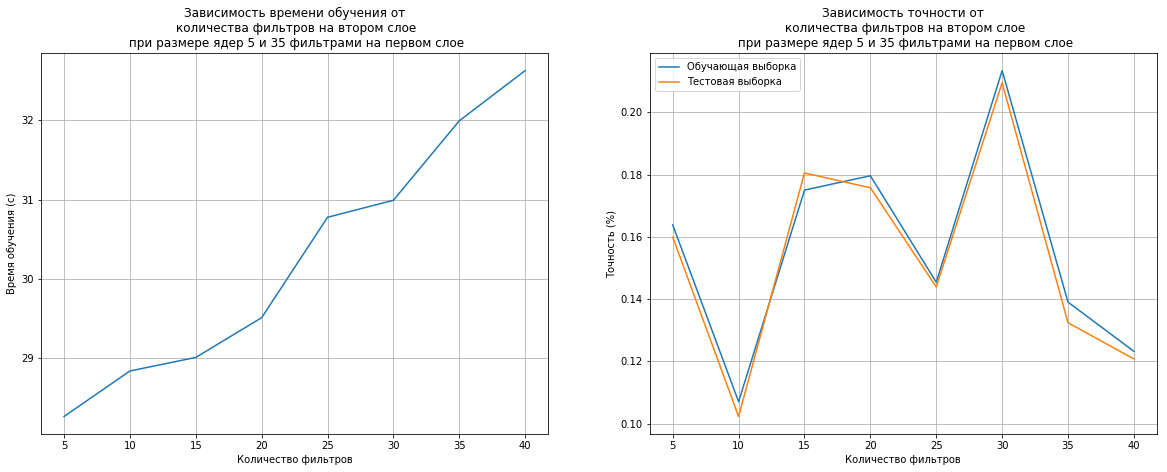

In [176]:
train_accuracy = []
for i in accuracy2:
    train_accuracy.append(i[0])
    
test_accuracy = []
for i in accuracy2:
    test_accuracy.append(i[1])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

ax1.plot(filters_num_list, times2)
ax1.set_title(u"Зависимость времени обучения от\n количества фильтров на втором слое\n при размере ядер 5 и 35 фильтрами на первом слое")
ax1.set_xlabel(u"Количество фильтров")
ax1.set_ylabel(u"Время обучения (с)")
ax1.grid()
ax1.legend()

ax2.plot(filters_num_list, train_accuracy, label="Обучающая выборка")
ax2.plot(filters_num_list, test_accuracy, label="Тестовая выборка")
ax2.set_title(u"Зависимость точности от\n количества фильтров на втором слое\n при размере ядер 5 и 35 фильтрами на первом слое")
ax2.set_xlabel(u"Количество фильтров")
ax2.set_ylabel(u"Точность (%)")
ax2.grid()
ax2.legend()

plt.show()

На графиках в ячейке [Зависимость точности от числа фильтров](#acc_filters) изображена зависимость точности классификации сверточной нейросети от количества фильтров а также зависимость времени обучения сверточной нейросети с двумя сверточными блоками от количества фильтров. Из графиков можно сделать схожие выводы, что и для сверточной нейросети с одним сверточным блоком: время обучения растет с увеличением количества блоков, а точность - с увеличением слоев. 

Рассмотрим время обучения и качество на обучающей и тестовой выборках, которые показывают нейросети с одним и двумя сверточными блоками соответственно.

In [177]:
auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=2, conv_out_channels=[35, 30], 
                                conv_kernel_size=[5, 5], conv_stride=[1, 1], pool_kernel_size=[2, 2],
                                pool_stride=[2, 2], conv_padding=[0, 0],linear_layers_num=3,linear_out_channels=[120, 84, 10])

In [178]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5)

start = time.time()
optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=30,
                     dataset=trainloader, AutoEncoder=False, show_progress=False)

print("Time elapsed: {:.3f}".format(time.time() - start))
compute_accuracy(auto_enc, testloader, AutoEncoder=False)

Time elapsed: 241.373
Accuracy on dataset: 0.460


0.46

In [179]:
auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=1, conv_out_channels=[35], 
                                conv_kernel_size=[5], conv_stride=[1], pool_kernel_size=[2],
                                pool_stride=[2], conv_padding=[0],linear_layers_num=3,linear_out_channels=[120, 84, 10])

In [180]:
criterion = nn.CrossEntropyLoss()

start = time.time()
optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5)

optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=30,
                     dataset=trainloader, AutoEncoder=False, show_progress=False)

print("Time elapsed: {:.3f}".format(time.time() - start))
print(compute_accuracy(auto_enc, testloader, AutoEncoder=False))

Time elapsed: 217.356
Accuracy on dataset: 0.494
0.494375


Как видно из приведенных выше результатов, сверточная нейросеть с одним блоком дает лучшее качество и быстрее обучается. Эту модель мы и будем использоваться для дальнейших экспериментов.

Протестируем, как использование momentum при обучение сетей влияет на время обучения и качество.

In [181]:
auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=1, conv_out_channels=[35], 
                                conv_kernel_size=[5], conv_stride=[1], pool_kernel_size=[2],
                                pool_stride=[2], conv_padding=[0],linear_layers_num=3,linear_out_channels=[120, 84, 10])

In [182]:
momentum = [0.7, 0.8, 0.9, 0.99]
criterion = nn.CrossEntropyLoss()
momentum_times = []

for m in momentum:
    print("Momentum: {}".format(m))
    auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=1, conv_out_channels=[35], 
                                conv_kernel_size=[5], conv_stride=[1], pool_kernel_size=[2],
                                pool_stride=[2], conv_padding=[0],linear_layers_num=3,linear_out_channels=[120, 84, 10])
    
    optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5, momentum=m)
    
    start = time.time()
    optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=10,
                 dataset=trainloader, AutoEncoder=False)
    momentum_times.append(time.time() - start)

    compute_accuracy(auto_enc, testloader, AutoEncoder=False)

Momentum: 0.7
[1,   500] loss: 2.265
[1,  1000] loss: 2.081
[2,   500] loss: 1.843
[2,  1000] loss: 1.828
[3,   500] loss: 1.702
[3,  1000] loss: 1.648
[4,   500] loss: 1.553
[4,  1000] loss: 1.535
[5,   500] loss: 1.454
[5,  1000] loss: 1.476
[6,   500] loss: 1.358
[6,  1000] loss: 1.376
[7,   500] loss: 1.295
[7,  1000] loss: 1.252
[8,   500] loss: 1.210
[8,  1000] loss: 1.201
[9,   500] loss: 1.093
[9,  1000] loss: 1.140
[10,   500] loss: 1.030
[10,  1000] loss: 1.073
Accuracy on dataset: 0.495
Momentum: 0.8
[1,   500] loss: 2.197
[1,  1000] loss: 1.960
[2,   500] loss: 1.768
[2,  1000] loss: 1.748
[3,   500] loss: 1.612
[3,  1000] loss: 1.555
[4,   500] loss: 1.443
[4,  1000] loss: 1.453
[5,   500] loss: 1.326
[5,  1000] loss: 1.341
[6,   500] loss: 1.230
[6,  1000] loss: 1.233
[7,   500] loss: 1.109
[7,  1000] loss: 1.175
[8,   500] loss: 1.034
[8,  1000] loss: 1.081
[9,   500] loss: 0.953
[9,  1000] loss: 1.000
[10,   500] loss: 0.838
[10,  1000] loss: 0.908
Accuracy on dataset: 

Лучшее качество и значение функции потерь достигается при коэффиценте $ \mu = 0.9 $.
![SGD and SGD with momentum](SGDcomp.png)
Как видно из кртинки, траектория стохастического градиентного спуска с моментумом начинает сильно колебаться около опутимума, поэтому будем использоваться следюущую стратегию: обучим модель, используя SGD с momentum, на пяти эпохах и после, используя стандартный SGD, еще на 20.

In [183]:
auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=1, conv_out_channels=[35], 
                                conv_kernel_size=[5], conv_stride=[1], pool_kernel_size=[2],
                                pool_stride=[2], conv_padding=[0],linear_layers_num=3,linear_out_channels=[120, 84, 10])

In [184]:
optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)

optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=5,
                     dataset=trainloader, AutoEncoder=False)

optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5)

optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=20,
                     dataset=trainloader, AutoEncoder=False, show_progress=False)

compute_accuracy(auto_enc, testloader, AutoEncoder=False)

[1,   500] loss: 2.139
[1,  1000] loss: 1.874
[2,   500] loss: 1.667
[2,  1000] loss: 1.599
[3,   500] loss: 1.477
[3,  1000] loss: 1.443
[4,   500] loss: 1.322
[4,  1000] loss: 1.321
[5,   500] loss: 1.147
[5,  1000] loss: 1.196
Accuracy on dataset: 0.523


0.523375

В результате, была получена точность в 52.3 %.

## Эксперимент №3

Целью данного эксперимента является поиск наилучших параметров для сверточного автокодировщика с одним блоком. Оценивать качество работы автокодировщика будем как среднеквадратичные потери между изображениями из тестовой выборки и результатом работы автокодировщика.

In [203]:
auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=1, conv_out_channels=[9], conv_kernel_size=[5], 
                           conv_stride=[1], pool_kernel_size=[2], pool_stride=[2], conv_padding=[2],
                           linear_layers_num=3, linear_out_channels=[120, 84, 10])

auto_enc.parameters

<bound method Module.parameters of ConvAutoEncoder(
  (conv): ModuleList(
    (0): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): ModuleList(
    (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (unpool): ModuleList(
    (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (convTrans): ModuleList(
    (0): ConvTranspose2d(9, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (linear): ModuleList(
    (0): Linear(in_features=2304, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)>

In [204]:
criterion = nn.MSELoss()

optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)

optimize_encoder(net=auto_enc, criterion=criterion, optimizer=optimizer, dataset=unlabeledloader, num_epochs=3, show_progress=False)

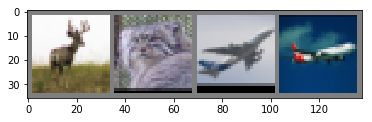

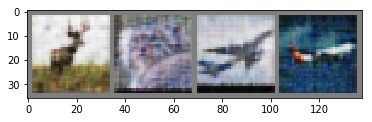

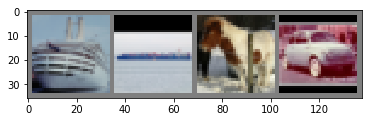

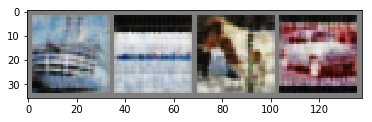

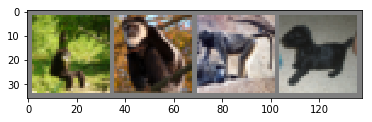

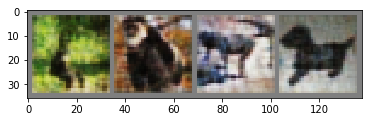

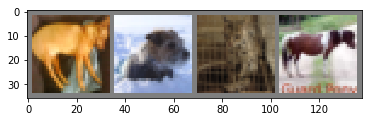

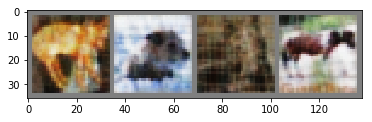

In [187]:
testiter = iter(testloader)

for i in range(4):
    data, _ = next(testiter)

    imshow(torchvision.utils.make_grid(data))

    plt.show()

    data = Variable(data)
    decoded_imgs = auto_enc(data)

    imshow(torchvision.utils.make_grid(decoded_imgs.data))

    plt.show()

Как видно из приведенных выше примеров, изображения стали более "зернистыми". Этот эффект возникает из-за наличия в автокодировщике pooling и unpooling слоев, в которых теряется некоторая часть информации.<br>

Средние квадратичные потери после работы автоэнкодера на тестовой выборке:

In [188]:
criterion = nn.MSELoss()
running_loss = 0.0
for i, data in enumerate(testloader):
    imgs, _ = data
    imgs = Variable(imgs)
    output = auto_enc(imgs)
    loss = criterion(output, imgs)
    running_loss += loss.data[0]
print("MSE on testset: {:.4f}".format(running_loss / i))

MSE on testset: 0.0111


В результате проведения эксперимента, были найдены удачные параметры для автокодировщика, было произведено обучение автокодировщика и получено значение среднеквадратичного отклонения изображений тестовой выборки от результатов работы автокодировщика в 0.011.

## Эксперимент №4

В данном эксперименте будет рассмотрено качество и время обучения моделей из первого эксперимента на объектах, полученных после работы энкодера.<br>
Воспользуемся энкодером, для того что перевести объекты из датасета в другое представление и далее обучим на новых объектах мультиномиальную регрессию и _RandomForestClassifier_.

In [189]:
mult_regression = MultinomialRegression(2304)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(mult_regression.parameters(), lr=0.001, weight_decay=1e-5)

for epoch in range(10):
    
    running_loss = 0;
    for i, data in enumerate(trainloader):
        imgs, labels = data
        imgs, labels = Variable(imgs), Variable(labels)
        optimizer.zero_grad()
        mod_imgs = auto_enc.forward(imgs, TransformObjects=True)
        outputs = mult_regression(mod_imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.data[0]
        if (i + 1) % 500 == 0:
            print("[{:d}, {:5d}] loss: {:.3f}".format(epoch + 1, i + 1, running_loss / 500))
            running_loss = 0

[1,   500] loss: 2.068
[1,  1000] loss: 1.905
[2,   500] loss: 1.758
[2,  1000] loss: 1.754
[3,   500] loss: 1.676
[3,  1000] loss: 1.681
[4,   500] loss: 1.599
[4,  1000] loss: 1.606
[5,   500] loss: 1.556
[5,  1000] loss: 1.586
[6,   500] loss: 1.551
[6,  1000] loss: 1.521
[7,   500] loss: 1.497
[7,  1000] loss: 1.500
[8,   500] loss: 1.474
[8,  1000] loss: 1.485
[9,   500] loss: 1.453
[9,  1000] loss: 1.455
[10,   500] loss: 1.431
[10,  1000] loss: 1.434


In [190]:
correct=0
total=0
for i, data in enumerate(testloader):
    images, labels = data
    outputs = mult_regression.forward(auto_enc.forward(Variable(images), TransformObjects=True))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()

print('Accuracy on dataset: {:.2f}'.format(correct / total))

Accuracy on dataset: 0.44


In [191]:
dataiter = iter(trainloader)
imgs, label = next(dataiter)
imgs = Variable(imgs)
imgs = auto_enc.forward(imgs, TransformObjects=True)
num_features = np.array(imgs.size()[1::]).prod()
X = np.empty((0, num_features))
y = []


for i, data in enumerate(trainloader):
    imgs, labels = data
    imgs = Variable(imgs)
    imgs = auto_enc.forward(imgs, TransformObjects=True)
    tmp = imgs.data.numpy().reshape(-1, num_features)
    X = np.vstack((X, tmp))
    y += list(labels)

y = np.array(y)

In [192]:
dataiter = iter(testloader)
imgs, label = next(dataiter)
imgs = Variable(imgs)
imgs = auto_enc.forward(imgs, TransformObjects=True) 
num_features = np.array(imgs.size()[1::]).prod()
X_test = np.empty((0, num_features))
y_test = []


for i, data in enumerate(testloader):
    imgs, labels = data
    imgs = Variable(imgs)
    imgs = auto_enc.forward(imgs, TransformObjects=True)
    tmp = imgs.data.numpy().reshape(-1, num_features)
    X_test = np.vstack((X_test, tmp))
    y_test += list(labels)

y_test = np.array(y_test)

In [193]:
cl = RandomForestClassifier(n_estimators=300)
cl.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [194]:
predictions = cl.predict(X_test)

In [195]:
print("Accuracy of RandomForestClassifier: {:2f}".format((predictions==y_test).sum() / y_test.shape[0]))

Accuracy of RandomForestClassifier: 0.455750


В обоих случаях можно наблюдать прирост в качестве классификации. Вместе с этим уменьшается время обучения, что объясняется сокращением количества признаков у объекта.<br>
Больший прирост качества классификации у мультиномиальный регрессии может объясняться тем, что в новом признаковом пространстве объекты стали лучше линейно разделимыми, что имеет большое значение для линейный моделей и почти не имеет значения для моделей, основанных на деревьях.

## Эксперимент №5

Целью данного эксперимента является применение обученного на неразмеченных данных автокодировщика для улучшения качества классификации.<br>
Рассмотрим сверточную нейросеть с параметрами энкодера из третьего эксперимента, обучим ее на train выборке и протестируем качество классификации на test выборке.

In [210]:
auto_enc_test = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=1, conv_out_channels=[9], conv_kernel_size=[5], 
                           conv_stride=[1], pool_kernel_size=[2], pool_stride=[2], conv_padding=[2],
                           linear_layers_num=3, linear_out_channels=[120, 84, 10])

auto_enc_test.parameters

<bound method Module.parameters of ConvAutoEncoder(
  (conv): ModuleList(
    (0): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): ModuleList(
    (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (unpool): ModuleList(
    (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (convTrans): ModuleList(
    (0): ConvTranspose2d(9, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (linear): ModuleList(
    (0): Linear(in_features=2304, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)>

In [211]:
optimizer = optim.SGD(auto_enc_test.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)

optimize_net(net=auto_enc_test, criterion=criterion, optimizer=optimizer, num_epochs=5,
                     dataset=trainloader, AutoEncoder=False, show_progress=False)

optimizer = optim.SGD(auto_enc_test.parameters(), lr=0.001, weight_decay=1e-5)

optimize_net(net=auto_enc_test, criterion=criterion, optimizer=optimizer, num_epochs=20,
                     dataset=trainloader, AutoEncoder=False, show_progress=False)

compute_accuracy(auto_enc_test, testloader, AutoEncoder=False)

Accuracy on dataset: 0.511


0.511125

Воспользуемся параметрами обученного энкодера в качестве инициализации для обучения сверточной нейросети на тренировочной выборке. Для этого просто продолжим процесс обучения энкодера, пропуская объекты не через декодер, а через три полносвязных слоя.

In [209]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)

optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=5,
                        dataset=trainloader, AutoEncoder=False, show_progress=False)

optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5)

optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=15,
                     dataset=trainloader, AutoEncoder=False, show_progress=False)

compute_accuracy(auto_enc, testloader, AutoEncoder=False)

Accuracy on dataset: 0.529


0.52875

Как можно видеть из значения точности, приведенной выше, качество классификации возросло. Таким образом веса, найденные для энкодера действительно наилучшим образом инициализируют веса сверточной нейросети, которая в дальнейшем обучается на train/test выборке.

## Бонусная часть


В бонусной части будет рассмотрен автокодировщик с двуями сверточными блоками и подобраны параметры, дающие наименьшее значение MSE на тестовой выборке. Далее с этим кодировщиком будут проведены четверый и пятый эксперименты.

Рассмотрим сверточный автокодировщик с двумя слоями и подребем параметры второго слоя таким образом, чтобы получить наименьшие потери на выходе.

In [212]:
auto_enc = ConvAutoEncoder(input_size=(3, 32, 32), layers_num=2, conv_out_channels=[10, 10], conv_kernel_size=[4, 4], 
                           conv_stride=[1, 1], pool_kernel_size=[2, 2], pool_stride=[2, 2], conv_padding=[2, 2],
                           linear_layers_num=3, linear_out_channels=[120, 84, 10])

auto_enc.parameters

<bound method Module.parameters of ConvAutoEncoder(
  (conv): ModuleList(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(10, 10, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
  (pool): ModuleList(
    (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (unpool): ModuleList(
    (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (convTrans): ModuleList(
    (0): ConvTranspose2d(10, 10, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ConvTranspose2d(10, 3, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
  (linear): ModuleList(
    (0): Linear(in_features=640, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=

In [213]:
criterion = nn.MSELoss()

optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)

optimize_encoder(net=auto_enc, criterion=criterion, optimizer=optimizer, dataset=unlabeledloader, num_epochs=3, show_progress=False)

Для уменьшения размерности изображений, получающихся на выходе энкодера, для обоих pooling слоев были выбраны значения параметра stride, равные двум.

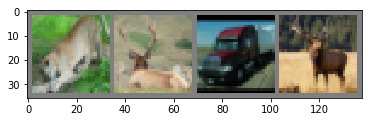

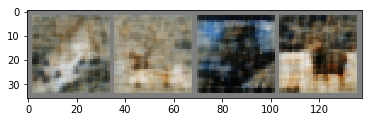

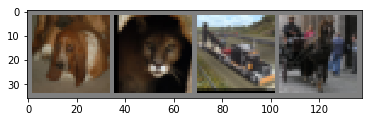

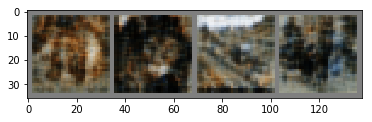

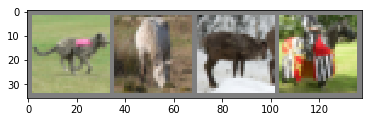

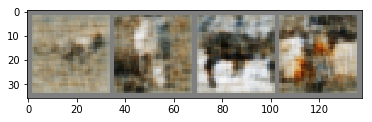

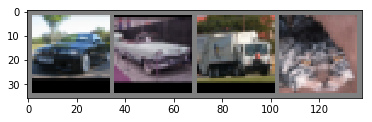

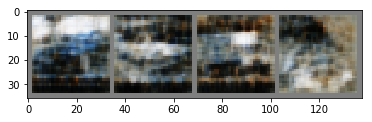

In [214]:
testiter = iter(testloader)

for i in range(4):
    data, _ = next(testiter)

    imshow(torchvision.utils.make_grid(data))

    plt.show()

    data = Variable(data)
    decoded_imgs = auto_enc(data)

    imshow(torchvision.utils.make_grid(decoded_imgs.data))

    plt.show()

Как видно из преобразованных изображений, они стали более зернистыми, чем после работы автокодировщика с одним сверточным блоком. Также наблюдается потеря некоторых цветов. Оба эффекта объясняются тем, что на pooling слоях теряется уже более существенное количество информации.

In [215]:
criterion = nn.MSELoss()
running_loss = 0.0
for i, data in enumerate(testloader):
    imgs, _ = data
    imgs = Variable(imgs)
    output = auto_enc(imgs)
    loss = criterion(output, imgs)
    running_loss += loss.data[0]
print("MSE on testset: {:.4f}".format(running_loss / i))

MSE on testset: 0.0252


Протестируем выделенные автоэнкодером признаки на моделях из первого эксперимента. Благодаря использованию двух pooling слоев со значением параметра stride, равным двум, количество признаков сократилось с 3072 до 640, что положительно сказалось на времени обучения.

In [216]:
mult_regression = MultinomialRegression(640)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(mult_regression.parameters(), lr=0.001, weight_decay=1e-5)

for epoch in range(10):
    
    running_loss = 0;
    for i, data in enumerate(trainloader):
        imgs, labels = data
        imgs, labels = Variable(imgs), Variable(labels)
        optimizer.zero_grad()
        mod_imgs = auto_enc.forward(imgs, TransformObjects=True)
        outputs = mult_regression(mod_imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [217]:
correct=0
total=0
for i, data in enumerate(testloader):
    images, labels = data
    outputs = mult_regression.forward(auto_enc.forward(Variable(images), TransformObjects=True))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()

print('Accuracy on dataset: {:.2f}'.format(correct / total))

Accuracy on dataset: 0.42


In [218]:
dataiter = iter(trainloader)
imgs, label = next(dataiter)
imgs = Variable(imgs)
imgs = auto_enc.forward(imgs, TransformObjects=True)
num_features = np.array(imgs.size()[1::]).prod()
X = np.empty((0, num_features))
y = []


for i, data in enumerate(trainloader):
    imgs, labels = data
    imgs = Variable(imgs)
    imgs = auto_enc.forward(imgs, TransformObjects=True)
    tmp = imgs.data.numpy().reshape(-1, num_features)
    X = np.vstack((X, tmp))
    y += list(labels)

y = np.array(y)

In [219]:
dataiter = iter(testloader)
imgs, label = next(dataiter)
imgs = Variable(imgs)
imgs = auto_enc.forward(imgs, TransformObjects=True) 
num_features = np.array(imgs.size()[1::]).prod()
X_test = np.empty((0, num_features))
y_test = []


for i, data in enumerate(testloader):
    imgs, labels = data
    imgs = Variable(imgs)
    imgs = auto_enc.forward(imgs, TransformObjects=True)
    tmp = imgs.data.numpy().reshape(-1, num_features)
    X_test = np.vstack((X_test, tmp))
    y_test += list(labels)

y_test = np.array(y_test)

In [220]:
cl = RandomForestClassifier(n_estimators=300)
cl.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [221]:
predictions = cl.predict(X_test)

In [222]:
print("Accuracy of RandomForestClassifier: {:2f}".format((predictions==y_test).sum() / y_test.shape[0]))

Accuracy of RandomForestClassifier: 0.465250


Как видно из данных, приведенных выше, качество классификации обоих моделей улучшилось по сравнению с первым экспериментом. Улучшение, как и в четвертом эксперименте, более существенно у мультиномиальой регрессии.

Теперь повторим пятый эксперимент, используя автокодировщик с двумя сверточными блоками.

In [223]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)

optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=5,
                        dataset=trainloader, AutoEncoder=False, show_progress=False)

optimizer = optim.SGD(auto_enc.parameters(), lr=0.001, weight_decay=1e-5)

optimize_net(net=auto_enc, criterion=criterion, optimizer=optimizer, num_epochs=20,
                     dataset=trainloader, AutoEncoder=False, show_progress=False)

count_accuracy(auto_enc, testloader, AutoEncoder=False)

Accuracy on dataset: 0.51


0.510625

Такая нейросеть уступает в точности сети, основанной на автокодировщиком с одним сверточным блоком, но переводит объекты в пространство гораздо более маленькой размерности, что может быть полезно в задачах, где рассматриваются изображения большего разрешения.

## Вывод

Итак, в ходе проведения исселдований, было изучено поведение моделей при различных значениях параметров, найдены наилучшие параметры для сверточной нейросети, обучаемой на train выборке и получена точность классификации в 52.3%. Также были найдены параметры для сверточного кодировщика с одним и двумя сверточными блоками, позволяющие снизить размерность объектов, а также наилучшим образом инициализировать веса нейросети, обучаемой на train выборке, и получить финальную точность классификации в 52.8%.